In [1]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images
!unzip labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [2]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [4]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

combined_dir = "chest_xray/dataset"

In [7]:
os.makedirs(combined_dir, exist_ok=True)

In [8]:
for category in os.listdir(train_dir):
  category_dir = os.path.join(train_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
  category_dir = os.path.join(test_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

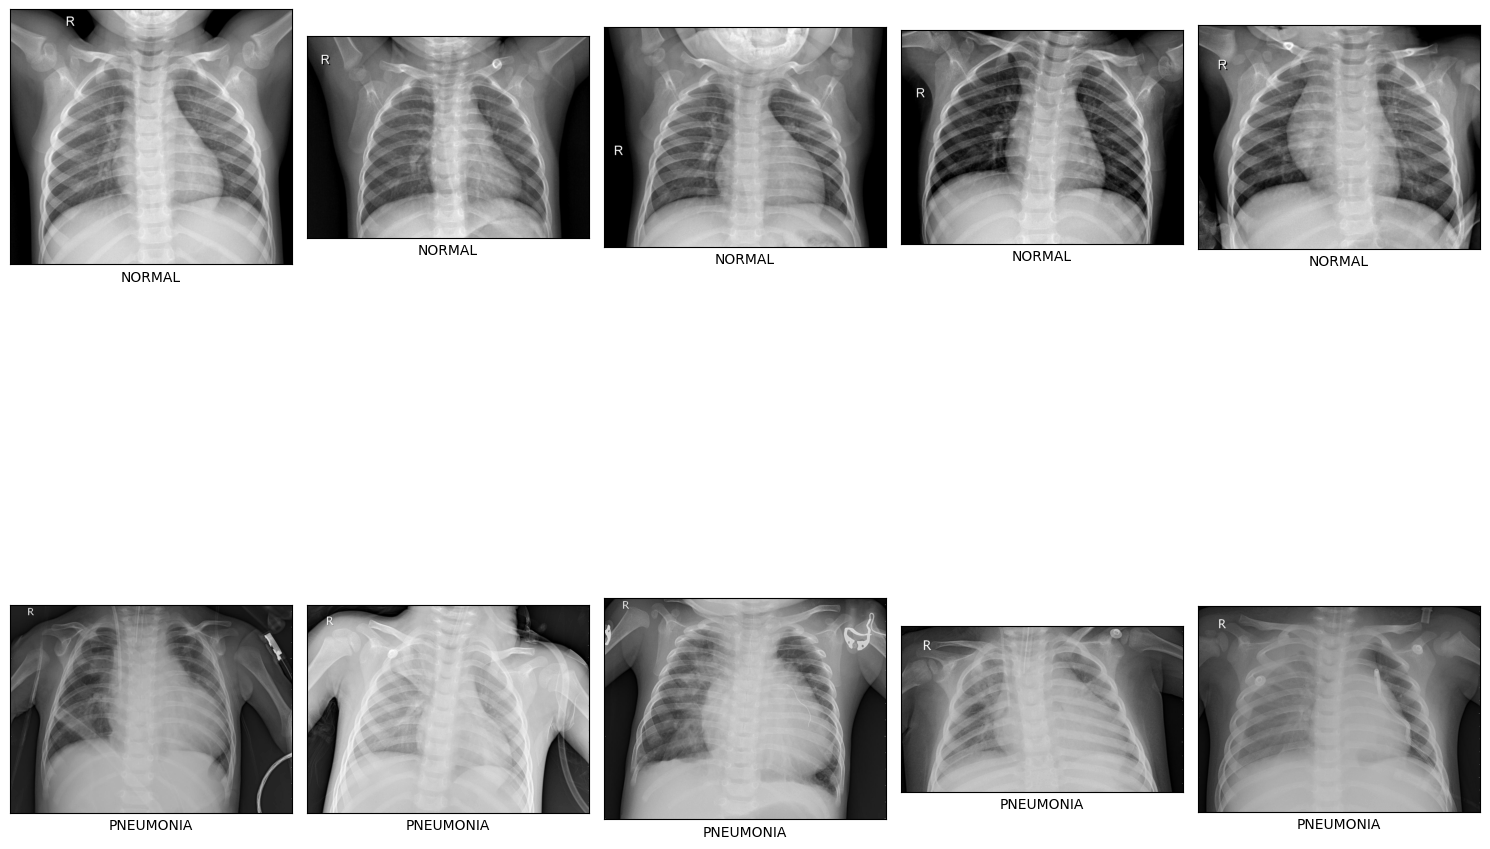

In [9]:
lung_image = {}

path = "chest_xray/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
  lung_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "chest_xray/dataset"

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(lung_image[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path).convert("L")
    axs[i, j].imshow(img, cmap='gray')
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

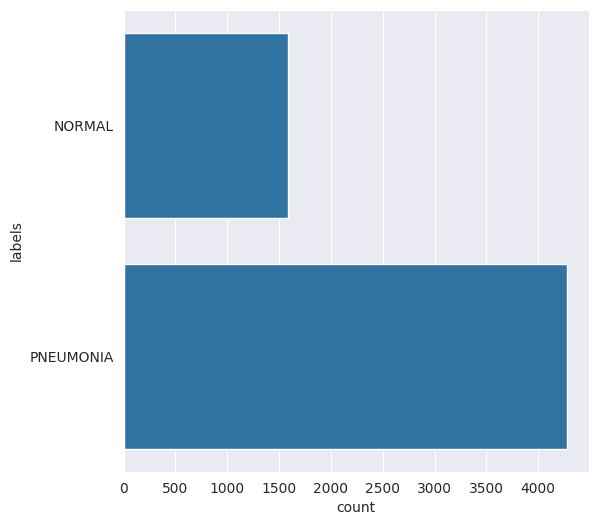

In [10]:
lung_path = "chest_xray/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split("/")[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

label = distribution_train["labels"]
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(label)

In [11]:
def anticlockwise_rotation(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (244, 244))
  sudut = random.randint(0, 180)
  return rotate(img, sudut)

def clockwise_rotatiton(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (244, 244))
  sudut = random.randint(0, 180)
  return rotate(img, -sudut)

def flip_up_down(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (244, 244))
  return np.flipud(img)

def add_brightness(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (244, 244))
  img = adjust_gamma(img, gamma=0.5, gain=1)
  return img

def blur_image(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (244, 244))
  return cv2.GaussianBlur(img, (9, 9), 0)

def sheared(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (244, 244))
  transform = AffineTransform(shear=0.2)
  shear_image = warp(img, transform, mode="wrap")
  return shear_image

def warp_shift(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (244, 244))
  transform = AffineTransform(translation=(0, 40))
  warp_image = warp(img, transform, mode="wrap")
  return warp_image

In [12]:
transformation = {
    "rotate anticlockwise": anticlockwise_rotation,
    "rotate clockwise": clockwise_rotatiton,
    "warp shift": warp_shift,
    "blurring image": blur_image,
    "add brightness": add_brightness,
    "flip up down": flip_up_down,
    "shear image": sheared
}

images_path = "chest_xray/dataset/NORMAL"
augmented_path = "chest_xray/dataset/NORMAL"
images = []

for im in os.listdir(images_path):
  images.append(os.path.join(images_path, im))

images_to_generate = 2000
i = 1

while i <= images_to_generate:
  image = random.choice(images)
  try:
    original_image = io.imread(image)
    transformed_image = None
    n = 0
    transformation_count = random.randint(1, len(transformation))

    while n <= transformation_count:
      key = random.choice(list(transformation))
      transformed_image = transformation[key](original_image)
      n = n + 1

    new_image_path = "%s/augmented_image_%s.jpeg" % (augmented_path, i)
    transformed_image = img_as_ubyte(transformed_image)
    cv2.imwrite(new_image_path, transformed_image)
    i = i + 1
  except ValueError as e:
    print("could not read the", image, ":", e, "hence skipping it.")

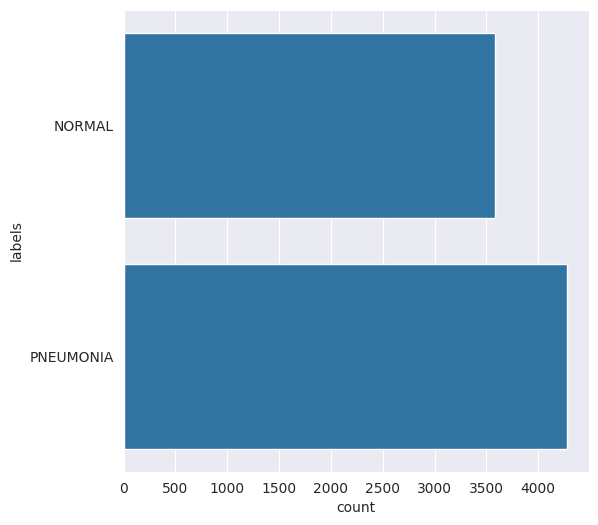

In [13]:
lung_path = "chest_xray/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split("/")[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

label = distribution_train["labels"]
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(label)

In [14]:
mypath = "chest_xray/dataset/"

file_names = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split("/")[-1])
    file_names.append(name)

df = pd.DataFrame({"path": full_path, "file_name": file_names, "labels": labels})
df.groupby([labels]).size()

NORMAL       3583
PNEUMONIA    4273
dtype: int64

In [15]:
X = df["path"]
y = df["labels"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300
)

In [16]:
df_tr = pd.DataFrame({"path": X_train, "labels": y_train, "set": "train"})
df_te = pd.DataFrame({"path": X_test, "labels": y_test, "set": "test"})

In [17]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print("===================================================== \n")
print(df_all.groupby(['set', 'labels']).size(), '\n')
print("===================================================== \n")

print(df_all.sample(5))

datasource_path = "chest_xray/dataset/"

dataset_path = "Dataset-Final/"


set    labels   
test   NORMAL        710
       PNEUMONIA     862
train  NORMAL       2873
       PNEUMONIA    3411
dtype: int64 


                                                   path     labels    set
3825  chest_xray/dataset/PNEUMONIA/BACTERIA-7364034-...  PNEUMONIA  train
5325  chest_xray/dataset/NORMAL/augmented_image_1372...     NORMAL  train
3899  chest_xray/dataset/PNEUMONIA/BACTERIA-6769685-...  PNEUMONIA  train
7694  chest_xray/dataset/PNEUMONIA/VIRUS-5066255-000...  PNEUMONIA   test
6650  chest_xray/dataset/PNEUMONIA/VIRUS-4805974-000...  PNEUMONIA   test


In [18]:
for index, row in tq(df_all.iterrows()):
  file_path = row["path"]
  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row["labels"], row["image"].split(".")[0])

  if os.path.exists(os.path.join(dataset_path, row["set"], row["labels"])) == False:
    os.makedirs(os.path.join(dataset_path, row["set"], row["labels"]))

  destination_file_name = file_path.split("/")[-1]
  file_dest = os.path.join(dataset_path, row["set"], row["labels"], destination_file_name)

  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

In [19]:
TRAIN_DIR = "Dataset-Final/train"
TEST_DIR = "Dataset-Final/test"

train_normal = os.path.join(TRAIN_DIR + "/NORMAL")
train_pneumonia = os.path.join(TRAIN_DIR + "/PNEUMONIA")
test_normal = os.path.join(TEST_DIR + "/NORMAL")
test_pneumonia = os.path.join(TEST_DIR + "/PNEUMONIA")

print("Total number of normal images in training set: ", len(os.listdir(train_normal)))
print("Total number of pneumonia images in training set: ", len(os.listdir(train_pneumonia)))
print("Total number of normal images in testing set: ", len(os.listdir(test_normal)))
print("Total number of pneumonia images in testing set: ", len(os.listdir(test_pneumonia)))

Total number of normal images in training set:  2873
Total number of pneumonia images in training set:  3411
Total number of normal images in testing set:  710
Total number of pneumonia images in testing set:  862


In [20]:
datagen = ImageDataGenerator(rescale=1 / 255.,
                             validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150, 150),
                                              color_mode="grayscale",
                                              class_mode="binary",
                                              subset="training",
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150, 150),
                                                   color_mode="grayscale",
                                                   class_mode="binary",
                                                   subset="validation",
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150, 150),
                                                  color_mode="grayscale",
                                                  class_mode="binary",
                                                  shuffle=False)

Found 5028 images belonging to 2 classes.
Found 1256 images belonging to 2 classes.
Found 1572 images belonging to 2 classes.


In [23]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(150, 150, 1)))
model.add(BatchNormalization())

model.add(Conv2D(32, (4, 4), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (7, 7), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss="binary_crossentropy",
              metrics=["accuracy"])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_3 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      16416     
                                                                 
 batch_normalization_4 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                      

In [24]:
count_normal, count_pneumia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumia) / 2.0
weight_1 = (1 / count_pneumia) * (count_pneumia + count_normal) / 2.0

class_weights = {0: weight_0, 1: weight_1}

%time

history = model.fit(train_generator,
                    epochs=30,
                    batch_size=32,
                    validation_data=validation_generator,
                    class_weight=class_weights)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Epoch 1/30
158/158 [==============================] - 35s 209ms/step - loss: 2.0416 - accuracy: 0.7701 - val_loss: 6.8426 - val_accuracy: 0.5430
Epoch 2/30
158/158 [==============================] - 33s 207ms/step - loss: 0.4485 - accuracy: 0.8417 - val_loss: 4.2312 - val_accuracy: 0.5430
Epoch 3/30
158/158 [==============================] - 34s 215ms/step - loss: 0.3322 - accuracy: 0.8837 - val_loss: 0.5041 - val_accuracy: 0.8742
Epoch 4/30
158/158 [==============================] - 32s 206ms/step - loss: 0.3089 - accuracy: 0.8946 - val_loss: 0.4598 - val_accuracy: 0.8041
Epoch 5/30
158/158 [==============================] - 34s 213ms/step - loss: 0.2480 - accuracy: 0.9167 - val_loss: 0.1652 - val_accuracy: 0.9435
Epoch 6/30
158/158 [==============================] - 35s 219ms/step - loss: 0.2050 - accuracy: 0.9342 - val_loss: 0.2962 - val_accuracy: 0.9355
Epoch 7/30
158/158 [==============================] - 33s 208ms/ste

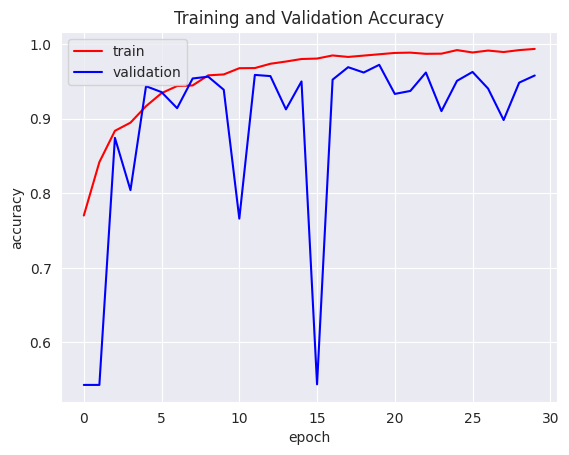

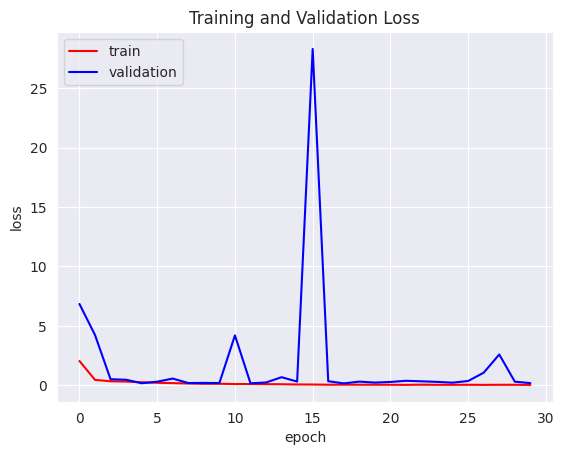

In [25]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title("Training and Validation Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(epochs, loss, "r")
plt.plot(epochs, val_loss, "b")
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()



              precision    recall  f1-score   support

      Normal     0.9716    0.9620    0.9667       710
   Pneumonia     0.9689    0.9768    0.9728       862

    accuracy                         0.9701      1572
   macro avg     0.9702    0.9694    0.9698      1572
weighted avg     0.9701    0.9701    0.9701      1572



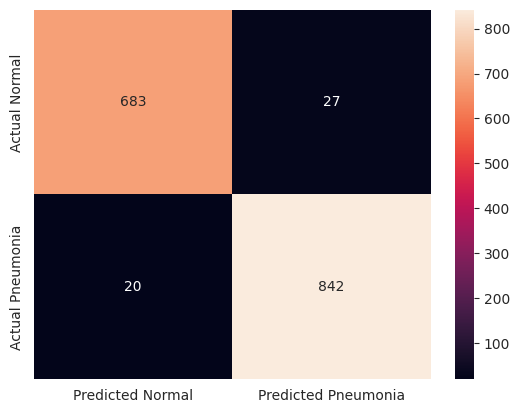

In [26]:
test_generator.reset()

pred = model.predict(test_generator, verbose=0)
pred = pred.copy()
pred[pred <= 0.5] = 0
pred[pred > 0.5] = 1

cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, pred, labels=[0, 1]), index=["Actual Normal", "Actual Pneumonia"], columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm, annot=True, fmt="d")

print("\n")
print(classification_report(y_true=test_generator.classes, y_pred=pred, target_names=["Normal", "Pneumonia"], digits=4))

In [27]:
model.save("chest-xray")

In [28]:
!zip -r chest-xray.zip chest-xray

  adding: chest-xray/ (stored 0%)
  adding: chest-xray/variables/ (stored 0%)
  adding: chest-xray/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: chest-xray/variables/variables.index (deflated 66%)
  adding: chest-xray/saved_model.pb (deflated 89%)
  adding: chest-xray/keras_metadata.pb (deflated 93%)
  adding: chest-xray/assets/ (stored 0%)
  adding: chest-xray/fingerprint.pb (stored 0%)
